# Sentiment and Emotion Analysis

This notebook documents the **Sentiment & Emotion Analysis pipeline** for the BSc thesis:  
`Debates, Media, and Discourse: A Computational Analysis of Temporal Shifts in U.S. Presidential Debates and Media Framing Across the Political Spectrum`, written by **Emma Cristina Mora** (emma.mora@studbocconi.it) at **Bocconi University** under the supervision of **Professor Carlo Rasmus Schwarz**.

The purpose of this stage is to measure **sentiment polarity** (positive / neutral / negative) and **emotional tone** (anger, fear, joy, sadness, disgust, surprise) in U.S. presidential debates (1960–2024) and in media coverage (Factiva articles from *New York Times*, *Wall Street Journal*, and *New York Post*, 2012–2024). This allows us to track how the **tone of discourse** has evolved over time and compare partisan debates to media outlets across the political spectrum.

**Sentiment Classification**
- Model: `cardiffnlp/twitter-roberta-base-sentiment-latest` (RoBERTa, 3-class).  
- Predictions: *positive, neutral, negative* with confidence scores.  
- Applied to:  
  - Debate utterances (≈ 9,300)  
  - Media chunks (balanced 675)  
- Outputs: slim datasets with `sentiment_label`, `sentiment_score`, and `sentiment_final` (after threshold filtering).

**Emotion Classification (Optional)**
- Model: `joeddav/distilbert-base-uncased-go-emotions-student` (GoEmotions).  
- Original 27 categories mapped into **Ekman’s 6 emotions** + *neutral*.  
- Applied to the same debates and media chunks.  
- Outputs: `emotion_label`, `emotion_score`, and `emotion_final` (after filtering).

**Quality Control**
- Section 5 explores score distributions and confidence margins for both sentiment and emotions.  
- Thresholds were applied, marking uncertain predictions as `"unspecified"`.  
- Results show that media often contain noisier sentiment/emotion signals compared to debates.

**Notebook Summary**
- Section 1: Setup and configuration (libraries, file paths, constants).  
- Section 2: Load debates and media datasets.  
- Section 3: Model setup (RoBERTa sentiment + GoEmotions with Ekman mapping).  
- Section 4: Apply classifiers to debates and media (slim outputs).  
- Section 5: Quality controls, distributions, filtering, and exports.  
- Final exports:  
  - `debates_sentiment_emotions.csv`  
  - `media_sentiment_emotions.csv`

## 1. Introduction and Config

In [18]:
# === LIBRARIES ===

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tqdm

In [19]:
# === PATHS & CONSTANTS ===

from google.colab import drive
drive.mount('/content/drive')

REPO_DIR   = REPO_DIR = Path("/content/drive/MyDrive/thesis/data/")

DEBATES_FILE = REPO_DIR / "debates" / "topic modeling" / "debates_df_themes.csv"
MEDIA_FILE  = REPO_DIR / "debates-media alignment" / "media_chunks_pred_balanced.csv"

# confirm setup
print("Repository Path:", REPO_DIR)
print("Debates Dataset:", DEBATES_FILE)
print("Media Dataset:", MEDIA_FILE)

# reproducibility
RANDOM_SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repository Path: /content/drive/MyDrive/thesis/data
Debates Dataset: /content/drive/MyDrive/thesis/data/debates/topic modeling/debates_df_themes.csv
Media Dataset: /content/drive/MyDrive/thesis/data/debates-media alignment/media_chunks_pred_balanced.csv


## 2. Load Data

In [20]:
# === DEBATES DATASET (whole data) ===

# load debates dataset and inspect schema
df_debates = pd.read_csv(DEBATES_FILE)

print(f"[INFO] Debates dataset (full) loaded: {len(df_debates):,} rows")
print(df_debates.head(3))
print("\n[INFO] Columns:", list(df_debates.columns))

[INFO] Debates dataset (full) loaded: 6,316 rows
                                                text speaker_normalized  \
0  good evening. the television and radio station...          Moderator   
1  mr. smith, mr. nixon. in the election of 1860,...        Candidate_D   
2  mr. smith, senator kennedy. the things that se...        Candidate_R   

     speaker       party   winner winner_party  year   debate_type  \
0  Moderator         NaN  Kennedy     Democrat  1960  presidential   
1    Kennedy    Democrat  Kennedy     Democrat  1960  presidential   
2      Nixon  Republican  Kennedy     Democrat  1960  presidential   

                           debate_id                           utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_004   

                                     lemmatized_text

In [21]:
# === MEDIA DATASET (balanced per outlet) ===

# load media dataset and inspect schema
df_media = pd.read_csv(MEDIA_FILE)

print(f"[INFO] Media dataset (balanced) loaded: {len(df_media):,} rows")
print(df_media.head(3))
print("\n[INFO] Columns:", list(df_media.columns))

[INFO] Media dataset (balanced) loaded: 675 rows
   __media_id  year outlet                      source_theme  chunk_index  \
0         440  2016    nyp          healthcare_public_health            2   
1         444  2016    nyp          healthcare_public_health            1   
2         278  2024    nyp  foreign_policy_national_security            7   

                                          chunk_text  \
0  stone said. jonathan gruber, the mit professor...   
1  "we're thinking of having him in the spin room...   
2  iowa caucuses. trump was right when he accused...   

                   pred_theme  pred_sim                second_theme  \
0  healthcare_social_security  0.724106     public_health_pandemics   
1  healthcare_social_security  0.717676     public_health_pandemics   
2     judiciary_supreme_court  0.747351  healthcare_social_security   

   second_sim    margin                                      chunk_preview  \
0    0.448441  0.275665  stone said. jonathan gruber, 

## 3. Model Setup & Emotions Mapping

In [22]:
# === SENTIMENT MODEL SETUP ===
# CardiffNLP RoBERTa sentiment (3-class: positive / neutral / negative)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

SENTIMENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_classifier = pipeline(
    "text-classification",
    model=SENTIMENT_MODEL,
    tokenizer=SENTIMENT_MODEL,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True  # important to get probabilities for all 3 classes
)

print(f"[INFO] Sentiment model loaded: {SENTIMENT_MODEL}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[INFO] Sentiment model loaded: cardiffnlp/twitter-roberta-base-sentiment-latest


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [23]:
# === EMOTION MODEL SETUP ===
# GoEmotions student model (27 categories + neutral)
# we'll map them later to 6 Ekman categories for interpretability

EMOTION_MODEL = "joeddav/distilbert-base-uncased-go-emotions-student"

emotion_classifier = pipeline(
    "text-classification",
    model=EMOTION_MODEL,
    tokenizer=EMOTION_MODEL,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

print(f"[INFO] Emotion model loaded: {EMOTION_MODEL}")

Device set to use cuda:0


[INFO] Emotion model loaded: joeddav/distilbert-base-uncased-go-emotions-student


In [24]:
# === EMOTIONS MAPPING (GoEmotions → Ekman 6 + Neutral) ===
# from Google GoEmotions paper (Demszky et al., 2020)

GOEMOTIONS_TO_EKMAN = {
    "admiration": "joy",
    "amusement": "joy",
    "approval": "joy",
    "caring": "joy",
    "desire": "joy",
    "excitement": "joy",
    "gratitude": "joy",
    "love": "joy",
    "optimism": "joy",
    "pride": "joy",
    "relief": "joy",

    "anger": "anger",
    "annoyance": "anger",
    "disapproval": "anger",

    "disgust": "disgust",

    "fear": "fear",
    "nervousness": "fear",

    "sadness": "sadness",
    "disappointment": "sadness",
    "embarrassment": "sadness",
    "grief": "sadness",
    "remorse": "sadness",

    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",

    "neutral": "neutral"  # keep neutral as is
}

print(f"[INFO] Mapping defined: {len(set(GOEMOTIONS_TO_EKMAN.values()))} categories")
print("Categories:", sorted(set(GOEMOTIONS_TO_EKMAN.values())))

[INFO] Mapping defined: 7 categories
Categories: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [25]:
# === HELPER FUNCTIONS ===

def classify_sentiment(texts):
    """
    Run sentiment classification (pos/neu/neg) on list of texts.
    Returns DataFrame with best label and score.
    """
    results = sentiment_classifier(
        texts,
        truncation=True,
        max_length=512,   # force cutoff at model’s limit
        padding=True      # pad shorter texts
    )
    rows = []
    for res in results:
        best = max(res, key=lambda x: x["score"])
        rows.append({
            "sentiment_label": best["label"].lower(),
            "sentiment_score": float(best["score"]),
            "sentiment_probs": {r["label"].lower(): r["score"] for r in res}
        })
    return pd.DataFrame(rows)


def classify_emotions(texts, batch_size=32):
    """
    Run GoEmotions classification on list of texts.
    Maps original 27 labels → Ekman 6 categories.
    Returns a DataFrame with best mapped label and score.
    """
    rows = []
    for i in tqdm.tqdm(range(0, len(texts), batch_size), desc="Classifying Emotions"):
        batch = texts[i:i+batch_size]
        results = emotion_classifier(
            batch,
            truncation=True,
            max_length=512,   # ensure model cutoff
            padding=True,
            return_all_scores=True
        )
        for res in results:
            # map to Ekman categories
            mapped_scores = {}
            for r in res:
                mapped = GOEMOTIONS_TO_EKMAN.get(r["label"], None)
                if mapped:
                    mapped_scores[mapped] = mapped_scores.get(mapped, 0.0) + r["score"]

            # pick best category
            best_label = max(mapped_scores, key=mapped_scores.get)
            best_score = mapped_scores[best_label]
            rows.append({
                "emotion_label": best_label,
                "emotion_score": float(best_score),
                "emotion_probs": mapped_scores
            })
    return pd.DataFrame(rows)

## 4. Apply to Datasets

### 4.1. Debates Dataset

In [26]:
# === CLASSIFY FULL DEBATES (SENTIMENT) ===

debate_texts = df_debates["text"].dropna().tolist()

debate_sent_batches = []
BATCH_SIZE = 32
for i in tqdm.tqdm(range(0, len(debate_texts), BATCH_SIZE), desc="Debates Sentiment"):
    batch = debate_texts[i:i+BATCH_SIZE]
    batch_df = classify_sentiment(batch)
    debate_sent_batches.append(batch_df)

debate_sent_full = pd.concat(debate_sent_batches, axis=0).reset_index(drop=True)

# slim dataframe
df_debates_sentiment = pd.DataFrame({
    "utterance_id": df_debates["utterance_id"],
    "text": df_debates["text"],
    "sentiment_label": debate_sent_full["sentiment_label"],
    "sentiment_score": debate_sent_full["sentiment_score"]
})

print("\n[INFO] Debates sentiment classification complete:", df_debates_sentiment.shape)
print(df_debates_sentiment.head())

Debates Sentiment: 100%|██████████| 198/198 [01:27<00:00,  2.27it/s]


[INFO] Debates sentiment classification complete: (6316, 4)
                            utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy_004   
3  1960_1_Presidential_Nixon_Kennedy_005   
4  1960_1_Presidential_Nixon_Kennedy_006   

                                                text sentiment_label  \
0  good evening. the television and radio station...        positive   
1  mr. smith, mr. nixon. in the election of 1860,...         neutral   
2  mr. smith, senator kennedy. the things that se...         neutral   
3  thank you, mr. nixon. that completes the openi...        positive   
4  senator, the vice president in his campaign ha...        negative   

   sentiment_score  
0         0.734504  
1         0.837423  
2         0.669891  
3         0.554536  
4         0.610444  


In [27]:
# === CLASSIFY FULL DEBATES (EMOTIONS) ===

debate_texts = df_debates["text"].dropna().tolist()

debate_emotions_batches = []
BATCH_SIZE = 32
for i in tqdm.tqdm(range(0, len(debate_texts), BATCH_SIZE), desc="Debates Emotions"):
    batch = debate_texts[i:i+BATCH_SIZE]
    batch_df = classify_emotions(batch, batch_size=BATCH_SIZE)
    debate_emotions_batches.append(batch_df)

debate_emotions_full = pd.concat(debate_emotions_batches, axis=0).reset_index(drop=True)

# slim dataframe
df_debates_emotions = pd.DataFrame({
    "utterance_id": df_debates["utterance_id"],
    "text": df_debates["text"],
    "emotion_label": debate_emotions_full["emotion_label"],
    "emotion_score": debate_emotions_full["emotion_score"]
})

print("\n[INFO] Debates emotion classification complete:", df_debates_emotions.shape)
print(df_debates_emotions.head())

Classifying Emotions:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(

Debates Emotions: 100%|██████████| 198/198 [00:48<00:00,  4.11it/s]


[INFO] Debates emotion classification complete: (6316, 4)
                            utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy_004   
3  1960_1_Presidential_Nixon_Kennedy_005   
4  1960_1_Presidential_Nixon_Kennedy_006   

                                                text emotion_label  \
0  good evening. the television and radio station...           joy   
1  mr. smith, mr. nixon. in the election of 1860,...           joy   
2  mr. smith, senator kennedy. the things that se...           joy   
3  thank you, mr. nixon. that completes the openi...           joy   
4  senator, the vice president in his campaign ha...         anger   

   emotion_score  
0       0.641503  
1       0.321501  
2       0.338791  
3       0.756695  
4       0.260542  


### 4.2. Media Dataset

In [28]:
# === CLASSIFY MEDIA (SENTIMENT) ===

media_texts = df_media["chunk_text"].dropna().tolist()

media_sent_batches = []
BATCH_SIZE = 32
for i in tqdm.tqdm(range(0, len(media_texts), BATCH_SIZE), desc="Media Sentiment"):
    batch = media_texts[i:i+BATCH_SIZE]
    batch_df = classify_sentiment(batch)
    media_sent_batches.append(batch_df)

media_sent_full = pd.concat(media_sent_batches, axis=0).reset_index(drop=True)

# slim dataframe
df_media_sentiment = pd.DataFrame({
    "chunk_index": df_media["chunk_index"],
    "chunk_text": df_media["chunk_text"],
    "sentiment_label": media_sent_full["sentiment_label"],
    "sentiment_score": media_sent_full["sentiment_score"]
})

print("\n[INFO] Media sentiment classification complete:", df_media_sentiment.shape)
print(df_media_sentiment.head())

Media Sentiment: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


[INFO] Media sentiment classification complete: (675, 4)
   chunk_index                                         chunk_text  \
0            2  stone said. jonathan gruber, the mit professor...   
1            1  "we're thinking of having him in the spin room...   
2            7  iowa caucuses. trump was right when he accused...   
3            1  if the government stops fighting a lawsuit tha...   
4            1  foreign desk: stopping the ayatollahs' nukes n...   

  sentiment_label  sentiment_score  
0        negative         0.494473  
1         neutral         0.857393  
2         neutral         0.620738  
3        negative         0.523026  
4         neutral         0.674028  


In [32]:
# === CLASSIFY MEDIA (EMOTIONS) ===

media_texts = df_media["chunk_text"].dropna().tolist()

media_emotions_batches = []
BATCH_SIZE = 32
for i in tqdm.tqdm(range(0, len(media_texts), BATCH_SIZE), desc="Media Emotions"):
    batch = media_texts[i:i+BATCH_SIZE]
    batch_df = classify_emotions(batch, batch_size=BATCH_SIZE)
    media_emotions_batches.append(batch_df)

media_emotions_full = pd.concat(media_emotions_batches, axis=0).reset_index(drop=True)

# slim dataframe
df_media_emotions = pd.DataFrame({
    "chunk_index": df_media["chunk_index"],
    "chunk_text": df_media["chunk_text"],
    "emotion_label": media_emotions_full["emotion_label"],
    "emotion_score": media_emotions_full["emotion_score"]
})

print("\n[INFO] Media emotion classification complete:", df_media_emotions.shape)
print(df_media_emotions.head())

Classifying Emotions:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(

Media Emotions: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


[INFO] Media emotion classification complete: (675, 4)
   chunk_index                                         chunk_text  \
0            2  stone said. jonathan gruber, the mit professor...   
1            1  "we're thinking of having him in the spin room...   
2            7  iowa caucuses. trump was right when he accused...   
3            1  if the government stops fighting a lawsuit tha...   
4            1  foreign desk: stopping the ayatollahs' nukes n...   

  emotion_label  emotion_score  
0           joy       0.322961  
1           joy       0.340010  
2           joy       0.333045  
3           joy       0.299062  
4           joy       0.330131  


## 5. Quality Controls & Filtering

### 5.1. Sentiment QC

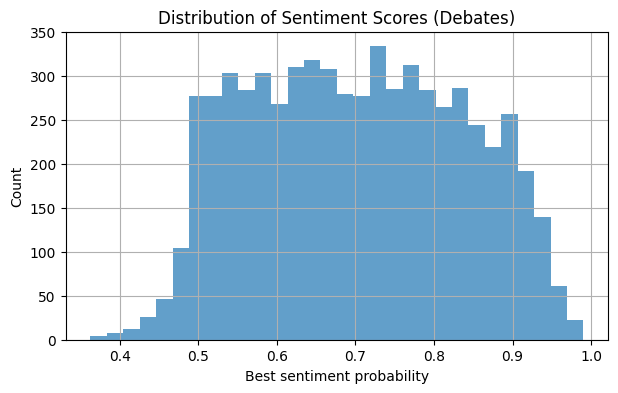

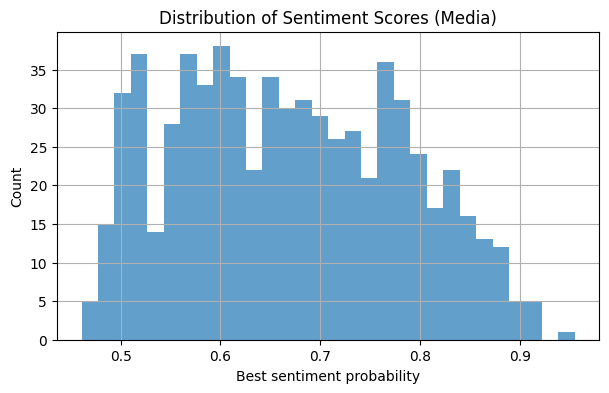

In [33]:
# === SENTIMENT QC: DISTRIBUTION OF SCORES ===

def plot_sentiment_scores(df, dataset_name="dataset"):
    plt.figure(figsize=(7,4))
    df["sentiment_score"].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution of Sentiment Scores ({dataset_name})")
    plt.xlabel("Best sentiment probability")
    plt.ylabel("Count")
    plt.show()

plot_sentiment_scores(df_debates_sentiment, "Debates")
plot_sentiment_scores(df_media_sentiment, "Media")

In [34]:
# === SENTIMENT QC: SUMMARY STATS ===

print("[INFO] Debates sentiment score stats:")
print(df_debates_sentiment["sentiment_score"].describe(), "\n")

print("[INFO] Media sentiment score stats:")
print(df_media_sentiment["sentiment_score"].describe())

[INFO] Debates sentiment score stats:
count    6316.000000
mean        0.700892
std         0.134329
min         0.362319
25%         0.588849
50%         0.699710
75%         0.810694
max         0.990331
Name: sentiment_score, dtype: float64 

[INFO] Media sentiment score stats:
count    675.000000
mean       0.669760
std        0.112715
min        0.460838
25%        0.576362
50%        0.662854
75%        0.765337
max        0.954917
Name: sentiment_score, dtype: float64


In [35]:
# === SENTIMENT QC: LABEL DISTRIBUTION (BEFORE FILTERING) ===

print("[INFO] Debates sentiment distribution (before):")
print(df_debates_sentiment["sentiment_label"].value_counts(normalize=True) * 100, "\n")

print("[INFO] Media sentiment distribution (before):")
print(df_media_sentiment["sentiment_label"].value_counts(normalize=True) * 100)

[INFO] Debates sentiment distribution (before):
sentiment_label
neutral     55.335655
negative    31.412286
positive    13.252058
Name: proportion, dtype: float64 

[INFO] Media sentiment distribution (before):
sentiment_label
neutral     66.222222
negative    30.222222
positive     3.555556
Name: proportion, dtype: float64


### 5.2. Sentiment Filtering

In [36]:
# === SENTIMENT FILTERING ===
SENTIMENT_THRESH = 0.50

df_debates_sentiment["sentiment_final"] = df_debates_sentiment.apply(
    lambda row: row["sentiment_label"] if row["sentiment_score"] >= SENTIMENT_THRESH else "unspecified",
    axis=1
)

df_media_sentiment["sentiment_final"] = df_media_sentiment.apply(
    lambda row: row["sentiment_label"] if row["sentiment_score"] >= SENTIMENT_THRESH else "unspecified",
    axis=1
)

print("[INFO] Debates sentiment distribution (after filtering):")
print(df_debates_sentiment["sentiment_final"].value_counts(normalize=True) * 100, "\n")

print("[INFO] Media sentiment distribution (after filtering):")
print(df_media_sentiment["sentiment_final"].value_counts(normalize=True) * 100)

[INFO] Debates sentiment distribution (after filtering):
sentiment_final
neutral        52.153262
negative       29.797340
positive       12.507916
unspecified     5.541482
Name: proportion, dtype: float64 

[INFO] Media sentiment distribution (after filtering):
sentiment_final
neutral        64.148148
negative       28.000000
unspecified     4.296296
positive        3.555556
Name: proportion, dtype: float64


### 5.3. Emotions QC

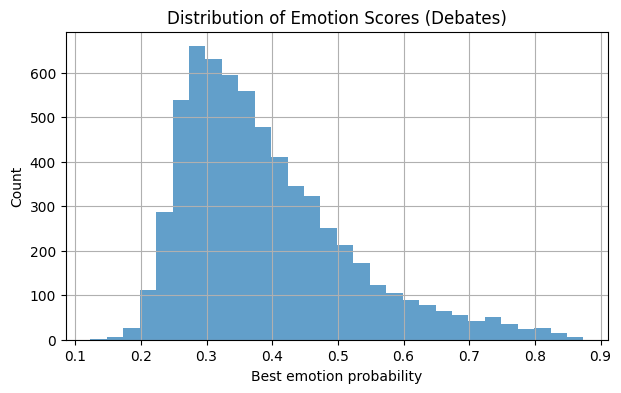

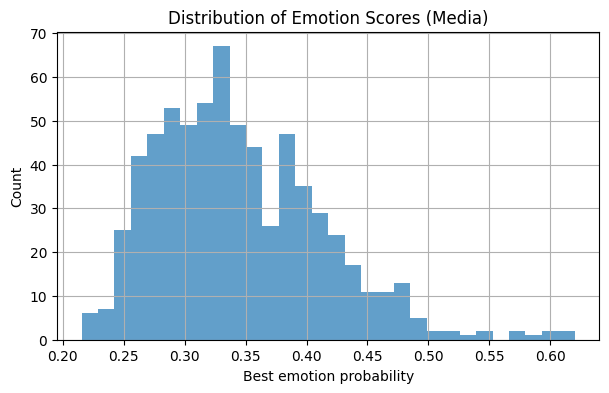

In [37]:
# === EMOTIONS QC: DISTRIBUTION OF SCORES ===

def plot_emotion_scores(df, dataset_name="dataset"):
    plt.figure(figsize=(7,4))
    df["emotion_score"].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution of Emotion Scores ({dataset_name})")
    plt.xlabel("Best emotion probability")
    plt.ylabel("Count")
    plt.show()

plot_emotion_scores(df_debates_emotions, "Debates")
plot_emotion_scores(df_media_emotions, "Media")

In [38]:
# === EMOTIONS QC: SUMMARY STATS ===

print("[INFO] Debates emotion score stats:")
print(df_debates_emotions["emotion_score"].describe(), "\n")

print("[INFO] Media emotion score stats:")
print(df_media_emotions["emotion_score"].describe())

[INFO] Debates emotion score stats:
count    6316.000000
mean        0.390033
std         0.125848
min         0.123068
25%         0.296535
50%         0.361047
75%         0.453804
max         0.873940
Name: emotion_score, dtype: float64 

[INFO] Media emotion score stats:
count    675.000000
mean       0.344931
std        0.067931
min        0.215411
25%        0.294157
50%        0.333045
75%        0.387657
max        0.620033
Name: emotion_score, dtype: float64


In [39]:
# === EMOTIONS QC: LABEL DISTRIBUTION (BEFORE FILTERING) ===

print("[INFO] Debates emotions distribution (before):")
print(df_debates_emotions["emotion_label"].value_counts(normalize=True) * 100, "\n")

print("[INFO] Media emotions distribution (before):")
print(df_media_emotions["emotion_label"].value_counts(normalize=True) * 100)

[INFO] Debates emotions distribution (before):
emotion_label
joy         72.735909
sadness     12.017099
surprise    10.402153
anger        4.559848
fear         0.269158
neutral      0.015833
Name: proportion, dtype: float64 

[INFO] Media emotions distribution (before):
emotion_label
joy         76.888889
sadness     14.074074
anger        5.777778
surprise     3.111111
fear         0.148148
Name: proportion, dtype: float64


### 5.4. Emotions Filtering

In [43]:
# === EMOTIONS FILTERING ===
EMOTION_THRESH = 0.35

df_debates_emotions["emotion_final"] = df_debates_emotions.apply(
    lambda row: row["emotion_label"] if row["emotion_score"] >= EMOTION_THRESH else "unspecified",
    axis=1
)

df_media_emotions["emotion_final"] = df_media_emotions.apply(
    lambda row: row["emotion_label"] if row["emotion_score"] >= EMOTION_THRESH else "unspecified",
    axis=1
)

print("[INFO] Debates emotions distribution (after filtering):")
print(df_debates_emotions["emotion_final"].value_counts(normalize=True) * 100, "\n")

print("[INFO] Media emotions distribution (after filtering):")
print(df_media_emotions["emotion_final"].value_counts(normalize=True) * 100)

[INFO] Debates emotions distribution (after filtering):
emotion_final
joy            46.041799
unspecified    45.962635
sadness         4.639012
surprise        2.169094
anger           1.044965
fear            0.142495
Name: proportion, dtype: float64 

[INFO] Media emotions distribution (after filtering):
emotion_final
unspecified    58.666667
joy            36.296296
sadness         3.259259
anger           1.481481
surprise        0.296296
Name: proportion, dtype: float64


## 6. Exports

In [44]:
# === MERGE DEBATES SENTIMENT + EMOTIONS ===

df_debates_final = pd.DataFrame({
    "utterance_id": df_debates_sentiment["utterance_id"],
    "text": df_debates_sentiment["text"],

    # sentiment
    "sentiment_label": df_debates_sentiment["sentiment_label"],
    "sentiment_score": df_debates_sentiment["sentiment_score"],
    "sentiment_final": df_debates_sentiment["sentiment_final"],

    # emotions
    "emotion_label": df_debates_emotions["emotion_label"],
    "emotion_score": df_debates_emotions["emotion_score"],
    "emotion_final": df_debates_emotions["emotion_final"]
})

OUT_DIR = REPO_DIR / "sentiment_emotion"
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_DEBATES = OUT_DIR / "debates_sentiment_emotions.csv"
df_debates_final.to_csv(OUT_DEBATES, index=False)

print("[DONE] Debates combined dataset saved:", OUT_DEBATES)
print(df_debates_final.head())

[DONE] Debates combined dataset saved: /content/drive/MyDrive/thesis/data/sentiment_emotion/debates_sentiment_emotions.csv
                            utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy_004   
3  1960_1_Presidential_Nixon_Kennedy_005   
4  1960_1_Presidential_Nixon_Kennedy_006   

                                                text sentiment_label  \
0  good evening. the television and radio station...        positive   
1  mr. smith, mr. nixon. in the election of 1860,...         neutral   
2  mr. smith, senator kennedy. the things that se...         neutral   
3  thank you, mr. nixon. that completes the openi...        positive   
4  senator, the vice president in his campaign ha...        negative   

   sentiment_score sentiment_final emotion_label  emotion_score emotion_final  
0         0.734504        positive           joy       0.641503           joy  
1         0.837423 

In [46]:
# === MERGE MEDIA SENTIMENT + EMOTIONS ===

df_media_final = pd.DataFrame({
    "chunk_index": df_media_sentiment["chunk_index"],   # or df_media.index if no chunk_id column
    "chunk_text": df_media_sentiment["chunk_text"],

    # sentiment
    "sentiment_label": df_media_sentiment["sentiment_label"],
    "sentiment_score": df_media_sentiment["sentiment_score"],
    "sentiment_final": df_media_sentiment["sentiment_final"],

    # emotions
    "emotion_label": df_media_emotions["emotion_label"],
    "emotion_score": df_media_emotions["emotion_score"],
    "emotion_final": df_media_emotions["emotion_final"]
})

OUT_MEDIA = OUT_DIR / "media_sentiment_emotions.csv"
df_media_final.to_csv(OUT_MEDIA, index=False)

print("[DONE] Media combined dataset saved:", OUT_MEDIA)
print(df_media_final.head())

[DONE] Media combined dataset saved: /content/drive/MyDrive/thesis/data/sentiment_emotion/media_sentiment_emotions.csv
   chunk_index                                         chunk_text  \
0            2  stone said. jonathan gruber, the mit professor...   
1            1  "we're thinking of having him in the spin room...   
2            7  iowa caucuses. trump was right when he accused...   
3            1  if the government stops fighting a lawsuit tha...   
4            1  foreign desk: stopping the ayatollahs' nukes n...   

  sentiment_label  sentiment_score sentiment_final emotion_label  \
0        negative         0.494473     unspecified           joy   
1         neutral         0.857393         neutral           joy   
2         neutral         0.620738         neutral           joy   
3        negative         0.523026        negative           joy   
4         neutral         0.674028         neutral           joy   

   emotion_score emotion_final  
0       0.322961   unspe